In [19]:
library(tidyverse)
library(dplyr)
library(knitr)
library(ggplot2)

## Part 1: Data Description

**Players Dataset (players.csv)**

- **Observations**: 196 players  

| Variable (7 total)     | Type        | Description                            |
|:--------------|:----------------------|:-------------------------------------------------|
| `experience`  | Categorical (string) | Player experience level.                         |
| `subscribe`   | Boolean              | Whether the player subscribed to the newsletter. |
| `hashedEmail` | String               | Anonymized player identifier.                    |
| `played_hours`| Numeric (float)      | Total hours played by the player.                |
| `name`        | String               | Player's name or username.                       |
| `gender`      | Categorical (string) | Player's gender.                                 |
| `Age`         | Numeric (float)      | Player's age, contains 2 missing values.         |

- **Issues in the data**
    - There are missing values present in `Age`



**Sessions Dataset (`sessions.csv`)**

- **Observations**: 1535 individual gaming sessions  

| Variable (5 total)              | Type                  | Description                                          |
|:------------------------|:----------------------|:-----------------------------------------------------|
| `hashedEmail`          | String               | Anonymized player identifier linking to `players.csv`. |
| `start_time`           | String               | Session start timestamp.                             |
| `end_time`             | String               | Session end timestamp, 2 missing values.        |
| `original_start_time`  | Numeric (float)      | Original numeric timestamp for session start.       |
| `original_end_time`    | Numeric (float)      | Original numeric timestamp for session end, 2 missing values. |

- **Issues in the Data**
    - Missing values in `end_time` and `original_end_time`.  

## (2) Questions:

**Broad Question:**
*"What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"*

**Specific Question:**
*"Can player experience level, age, gender, and total hours played predict whether a player subscribes to the newsletter in the Minecraft server dataset?"*

---

**Response Variable (target):**
- `subscribe` (Boolean): Indicates if a player subscribes or not.

**Explanatory Variables (features):**
- `experience` (categorical): Player's experience level.
- `Age` (numeric): Player’s age.
- `gender` (categorical): Player’s gender.
- `played_hours` (numeric): Total hours played.

---

### **Data Utilization:**
The `players` dataset already contains each individual’s demographic and gaming-related characteristics (such as `Age`, `gender`, `experience`, `played_hours`, and `subscribe` status). Because our main question focuses on which player attributes predict newsletter subscription, this single table should be sufficient for our analysis, and the `sessions` dataset isn’t really necessary. 

We can start by loading the `players.csv` dataset with `read_csv()`, yielding a table where each row represents a single player (observation), including their `subscribe` status, `Age`, `gender`, `experience`, and `played_hours`—variables that directly relate to our question.

After, we can address missing values in `Age` by using a simple median-based imputation to keep the dataset size stable. Next, since `gender` and `experience` are already categorical, we will convert them into factors (via `as_factor()`) so that models can treat them as discrete categories. We will also make sure that `subscribe` is treated as a factor, to keep its “yes/no” nature. We will keep `played_hours` as numeric because it measures how many hours each player has spent on the server.

Finally, we can remove columns like `hashedEmail` or `name` if they're not necessary for analysis. The resulting tidy dataset will contain the primary attributes needed—`Age`, `gender`, `experience`, `played_hours`, and `subscribe`—to directly investigate if these characteristics can predict whether a player subscribes to the newsletter.




## 3) Exploratory Data Analysis and Visualization


1) Read the data in

In [5]:
players_data <- "https://raw.githubusercontent.com/kianshahnia/dsci_project/main/players.csv"
players <- read_csv(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


2) Turn the necessary variables into factors (minimal wrangling)

In [6]:
players <- players |>
  mutate(
    gender = as_factor(gender),
    experience = as_factor(experience),
    subscribe = as_factor(subscribe)
  )

3) Compute Mean Value of Each Quantitative Variable

In [18]:
mean_values <- players |> 
  summarize(
    mean_age = mean(Age, na.rm = TRUE),
    mean_played_hours = mean(played_hours, na.rm = TRUE)
  )

kable(mean_values, caption = "Mean Values of Player Data")



Table: Mean Values of Player Data

| mean_age| mean_played_hours|
|--------:|-----------------:|
| 20.52062|          5.845918|

**Visualizations of the data**


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


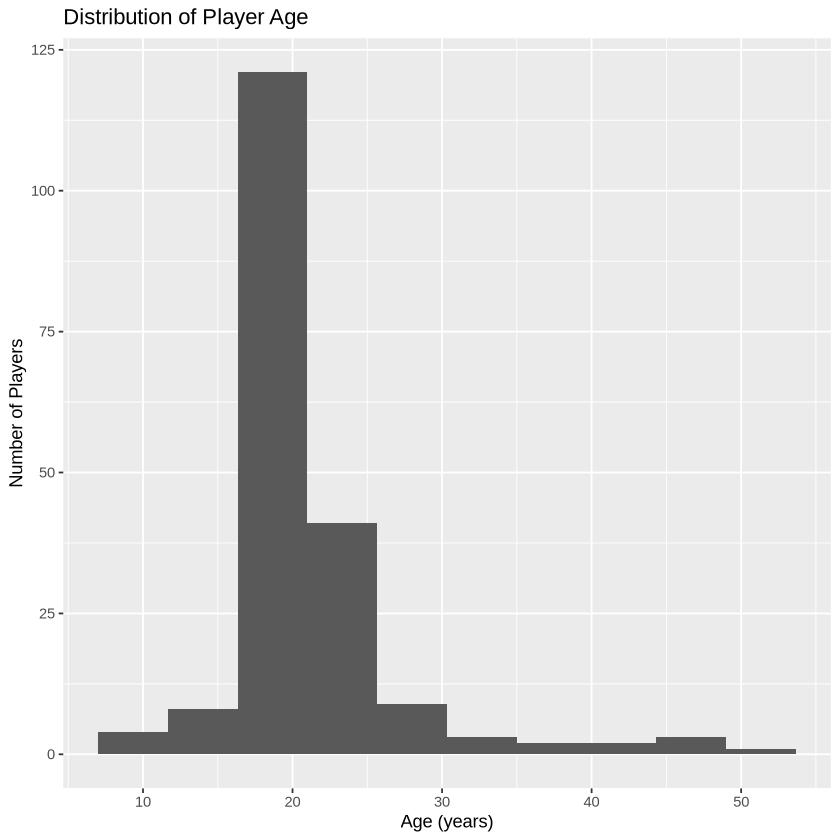

In [27]:
players |>
  ggplot(aes(x = Age)) +
  geom_histogram(bins = 10) +
  labs(
    title = "Distribution of Player Age",
    x = "Age (years)",
    y = "Number of Players"
  )

This Histogram of age helps us understand the distribution of player ages.

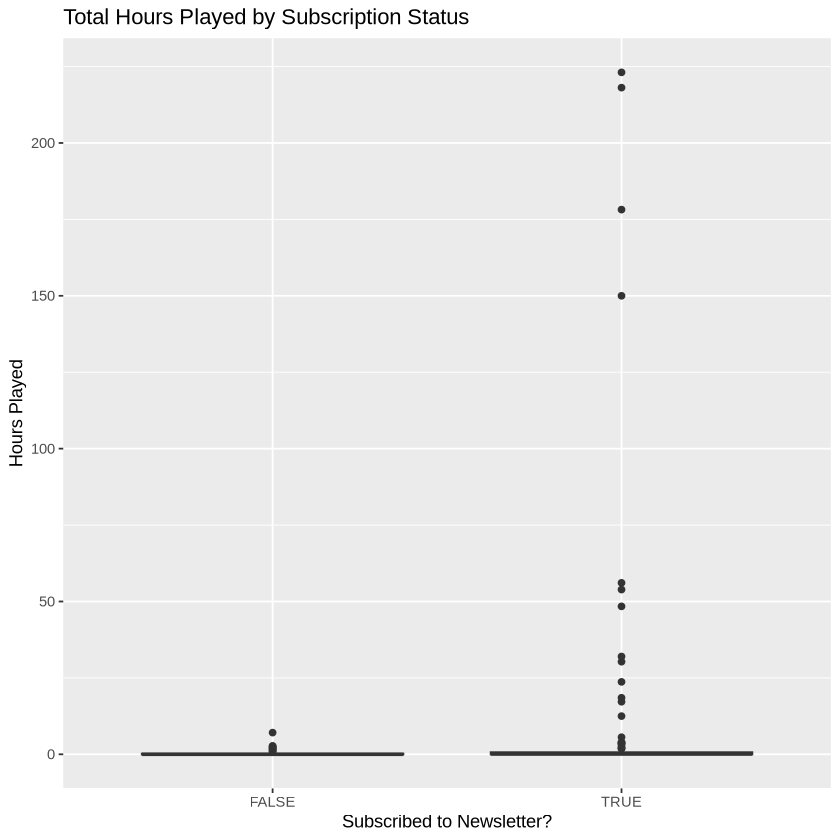

In [22]:
players |>
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(
    title = "Total Hours Played by Subscription Status",
    x = "Subscribed to Newsletter?",
    y = "Hours Played"
  )

This Boxplot of played hours by subscription helps compare how many hours subscribers vs non-subscribers have played

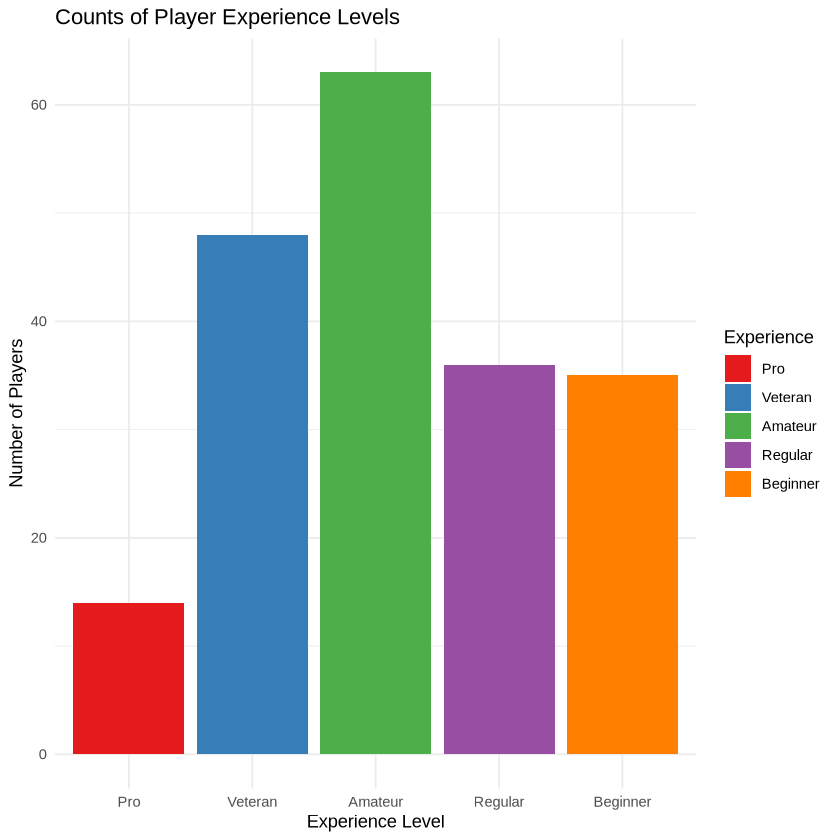

In [31]:
players |>
  ggplot(aes(x = experience, fill = experience)) +  
  geom_bar() +
  scale_fill_brewer(palette = "Set1") +  
  theme_minimal() +  
  labs(
    title = "Counts of Player Experience Levels",
    x = "Experience Level",
    y = "Number of Players",
    fill = "Experience"
  )

This Bar Chart of experience Levels shows the counts of each experience level

## (4) Exploratory Data Analysis and Visualization

We propose using K-Nearest Neighbors (KNN) regression as it can capture complex, non-linear relationships between our player-level predictors—such as experience level, age, gender, and hours played—and the outcome of newsletter subscription. The method assumes that each observation is independent, requires minimal missing values (which we plan to handle via simple imputation), and is sensitive to variable scale, so numeric features will be standardized while categorical variables like gender and experience will be one-hot encoded. Although KNN can effectively model intricate patterns without assuming linearity, it can be affected by outliers, irrelevant features, and large datasets due to its distance-based approach. To select the best number of neighbors (k), we will conduct cross-validation (for instance, five-fold), and we will split our data into a 70% training set for model fitting and a 30% test set for final evaluation. Performance could be measured with metrics like RMSE accuracy, allowing us to compare different values of k and ultimately choose the model that best balances predictive power and generalizability.